In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import powerlaw

In [10]:
df = pd.read_parquet('../Outputs/cleaned-5-player-features-camera-halves.parquet')
all_maps = df['mapName'].unique()
df.head()

,matchID,mapName,side,team,p1_name,p2_name,p3_name,p4_name,p5_name,p1_ch_area,...,p5_C1,p5_C2,p5_C3,p5_C4,p5_C5,p5_alpha_d,p5_num_samples_d,p5_num_samples_j,p5_alpha_j,Label
0,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,CT,Ninjas in Pyjamas,Plopski,REZ,es3tag,hampus,phzy,1424.941171,...,7.412956e-16,3907.747993,490.782712,28.556442,1211.922453,0.114353,227.0,2103.0,0.321310,de_inferno_CT
1,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,T,G2 Esports,AmaNEk,JACKZ,NiKo,huNter-,kennyS,1438.385548,...,4.624237e-19,1451.341573,206.108728,26.573975,1111.879645,0.092903,165.0,1874.0,0.522223,de_inferno_T
2,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,CT,Endpoint.CeX,CRUC1AL,MiGHTYMAX,Surreal,Thomas,mirbit,1411.646190,...,1.388183e-20,1255.468193,154.828216,18.984568,967.098412,0.086142,136.0,1646.0,0.487631,de_ancient_CT
3,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,T,SINNERS Esports,NEOFRAG,SHOCK,ZEDKO,beastik,oskar,1423.206417,...,3.929766e-21,3847.744122,303.103004,36.246863,1364.386421,0.124951,269.0,2373.0,0.493187,de_ancient_T
4,0657c9fd-a475-4257-8879-265fdbfd59b0,de_mirage,CT,Natus Vincere,Boombl4,Perfecto,b1t,electronic,s1mple,1431.687738,...,1.034189e-19,1889.985536,339.417794,31.391679,1476.095799,0.121139,205.0,2526.0,0.498844,de_mirage_CT


In [11]:
# Extract the metric names (excluding prefixes like p1_, p2_, etc.)
metrics = [
    'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed',
    'frac_dim',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'alpha_d', 'alpha_j', 'num_samples_d','num_samples_j'
]

# Statistic suffixes
stats = ['min', 'max', 'mean',  'std']

# List comprehension for output column names
output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

# Iterate through each metric and calculate row-wise stats
for metric in metrics:
    cols = [f'p{i+1}_{metric}' for i in range(5)]

    # Convert to a 2D array for row-wise operation
    data = df[cols].to_numpy()

    # Add new columns with row-wise aggregations
    df[f'{metric}_min'] = np.min(data, axis=1)
    df[f'{metric}_max'] = np.max(data, axis=1)
    df[f'{metric}_mean'] = np.mean(data, axis=1)
    df[f'{metric}_std'] = np.std(data, axis=1)

In [12]:
aggregate_df = df[['matchID', 'mapName', 'side', 'team', 'Label'] + output_columns]
aggregate_df.Label.value_counts()

Label
de_mirage_CT      130
de_mirage_T       130
de_inferno_CT     124
de_inferno_T      124
de_nuke_CT        115
de_nuke_T         115
de_ancient_CT      83
de_ancient_T       83
de_vertigo_CT      77
de_vertigo_T       76
de_overpass_CT     75
de_overpass_T      75
de_dust2_CT        75
de_dust2_T         75
Name: count, dtype: int64

In [13]:
# Note for 0 < a < 1 increasing alpha leads to a slower decay (higher probability of longer duration dwell/journey)
# Pick rate (see link below) seems to show players prefer maps where long dwells are less common and long journeys are less common (faster paced maps)
# https://www.hltv.org/stats/maps?startDate=2022-01-01&endDate=2022-12-31&rankingFilter=Top50

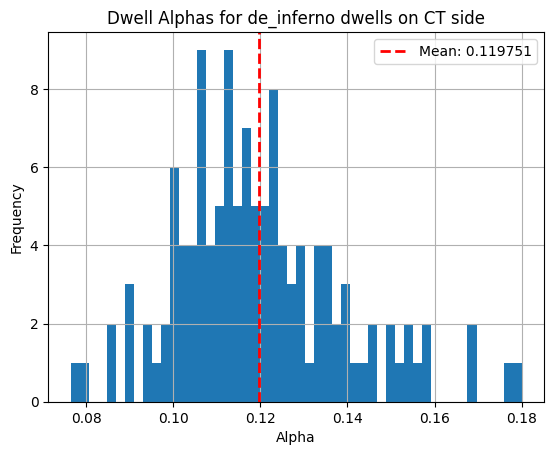

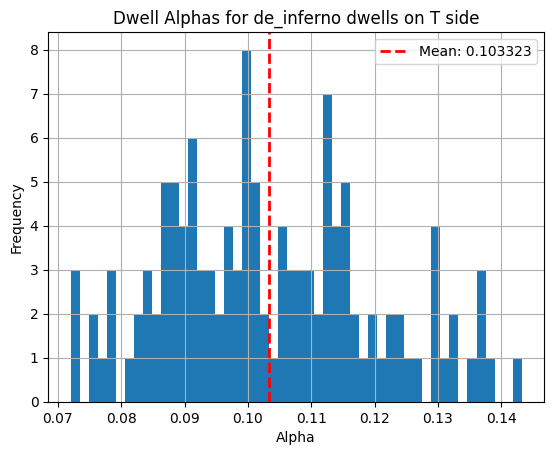

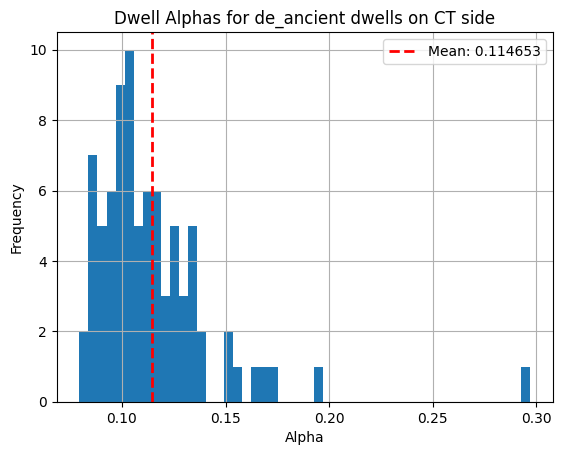

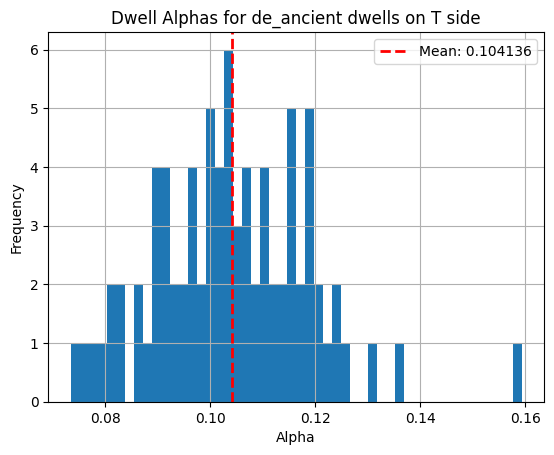

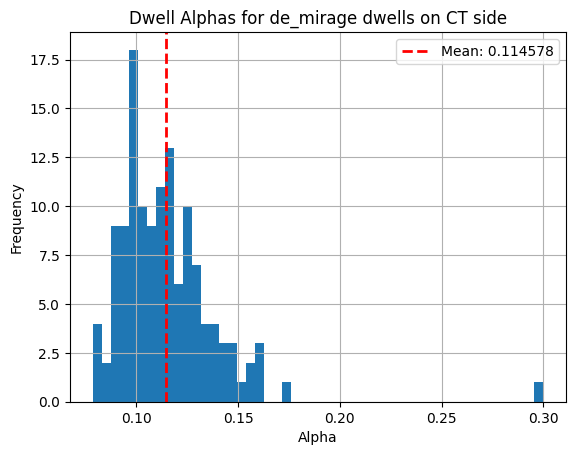

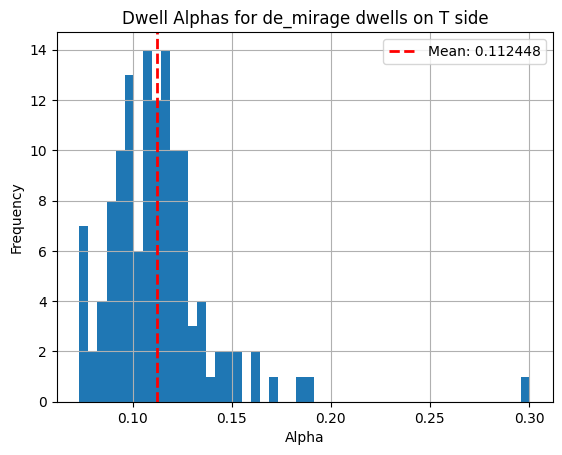

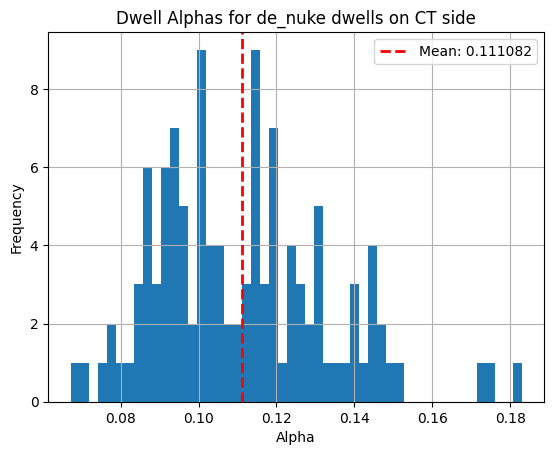

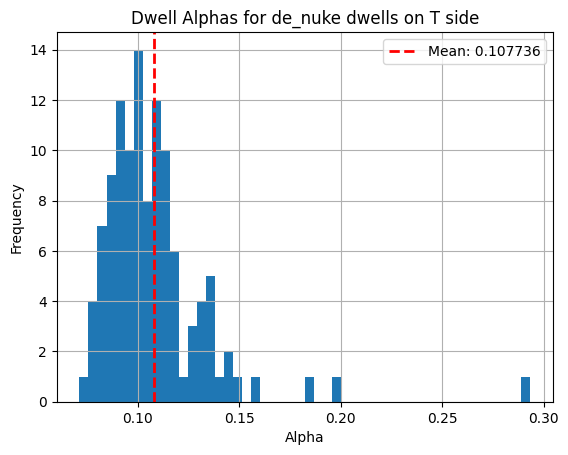

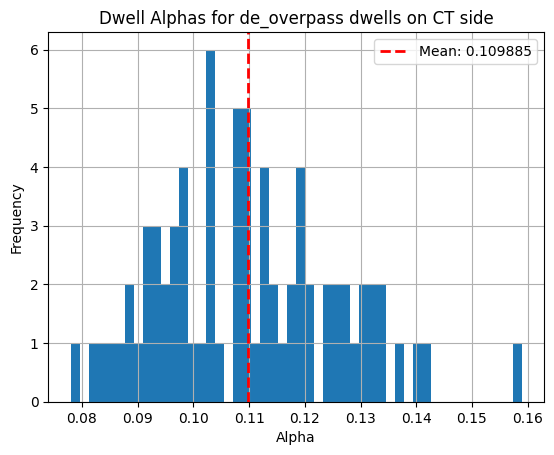

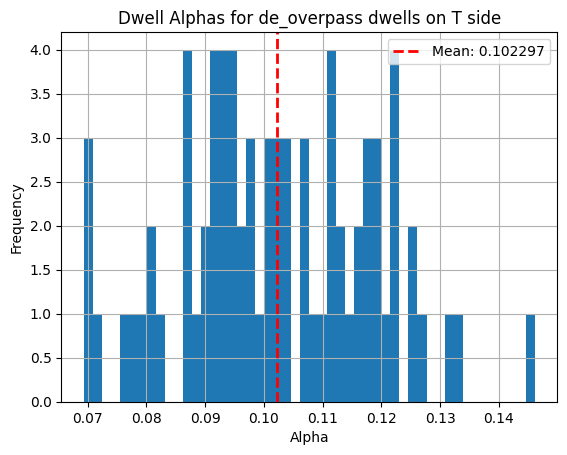

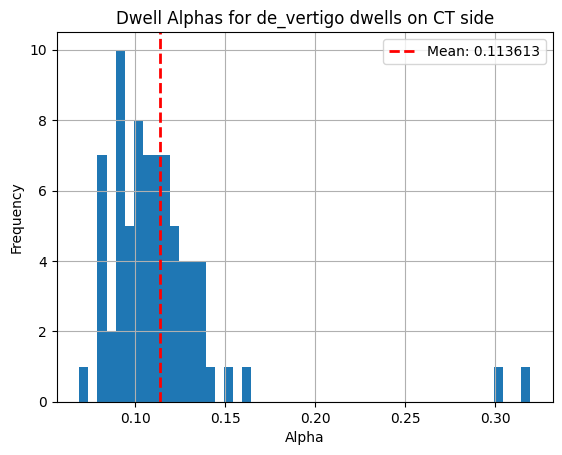

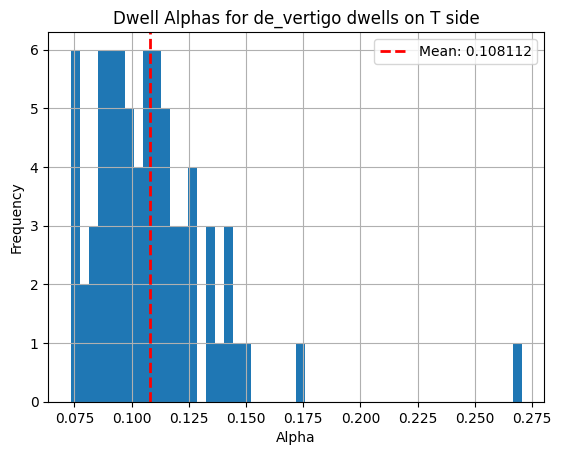

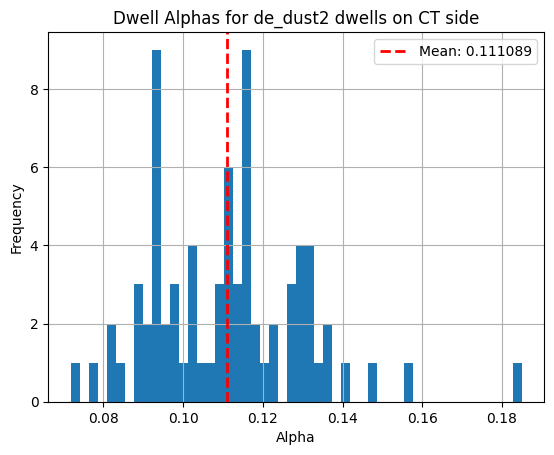

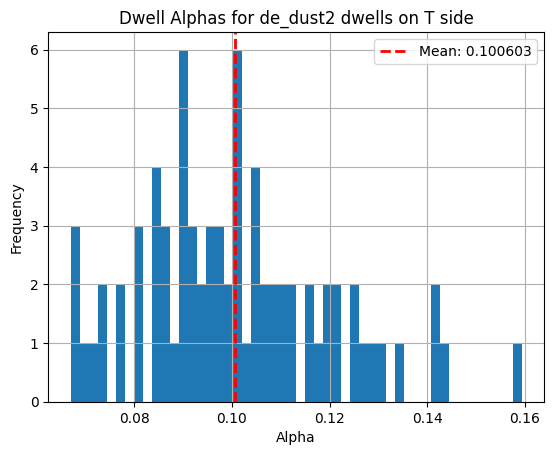

In [14]:
for map_name in all_maps:
    for s in aggregate_df.side.unique():
        plt.figure()  # Create a new figure for each histogram
        filtered_data = aggregate_df.loc[(aggregate_df['mapName'] == map_name) & (aggregate_df['side'] == s)]['alpha_d_mean']
        filtered_data = filtered_data[filtered_data <= 1]
        filtered_data.hist(bins=50)
        mean_alpha = filtered_data.mean()
        plt.axvline(mean_alpha, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_alpha:.6f}')
        
        plt.title(f"Dwell Alphas for {map_name} dwells on {s} side")
        plt.xlabel('Alpha')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()  # Display the histogram
    

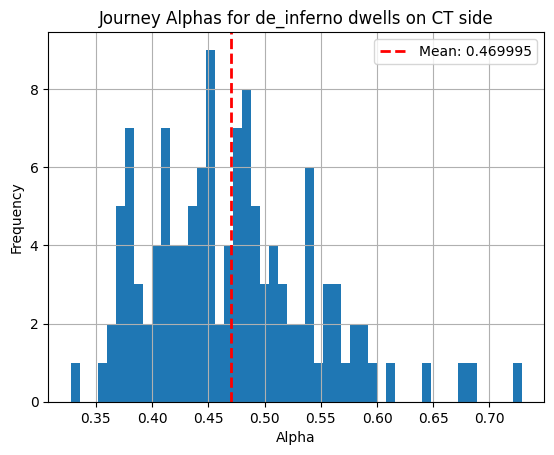

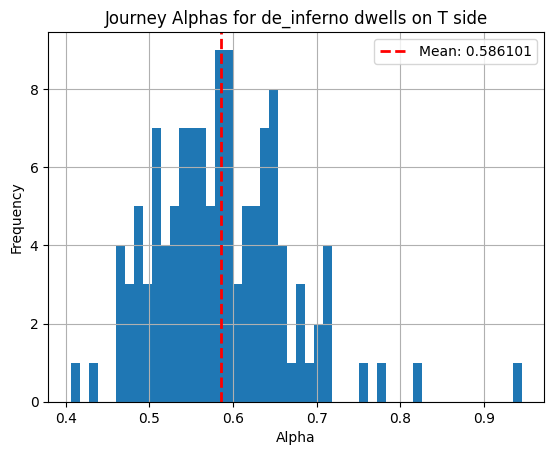

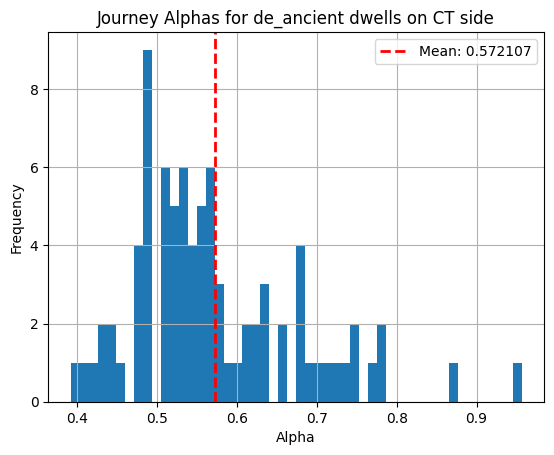

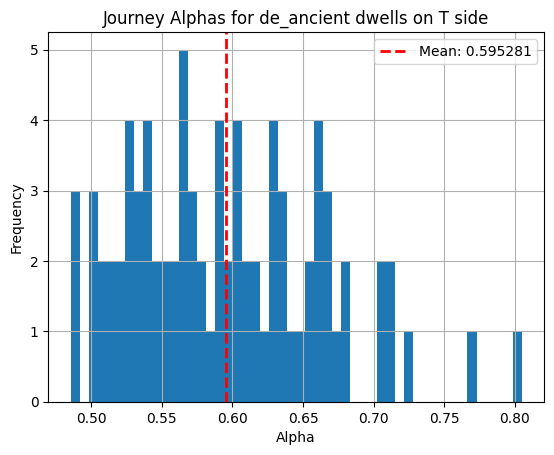

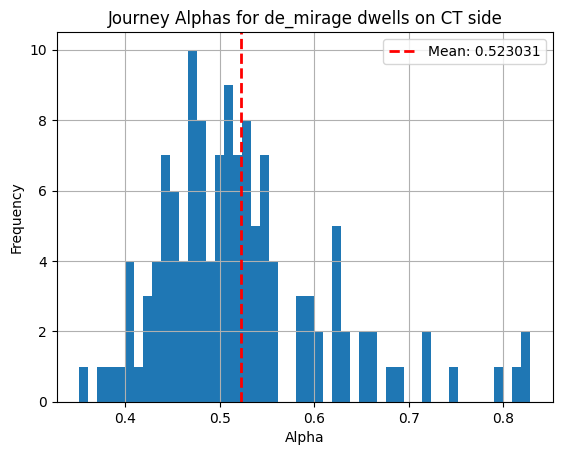

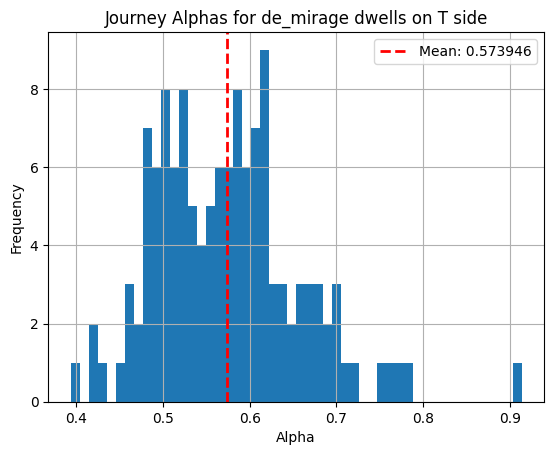

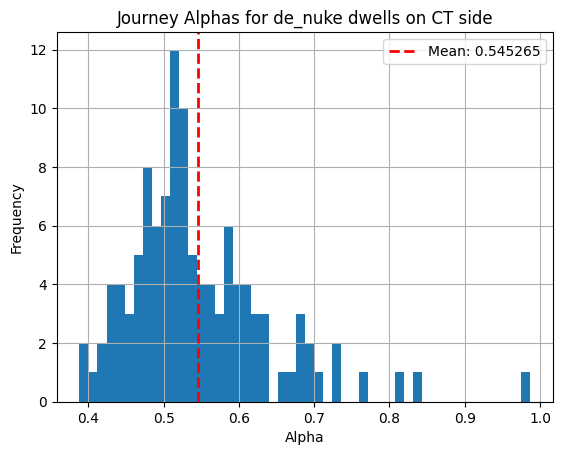

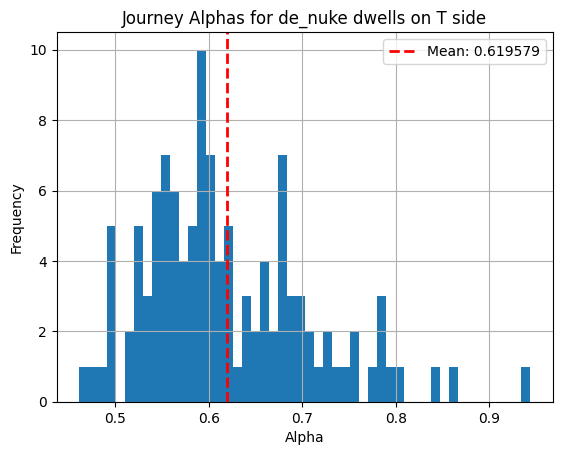

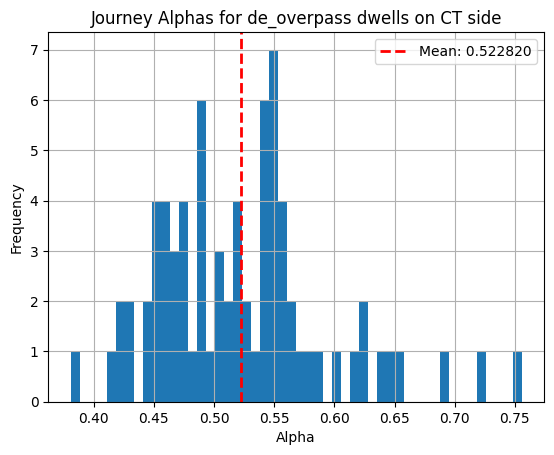

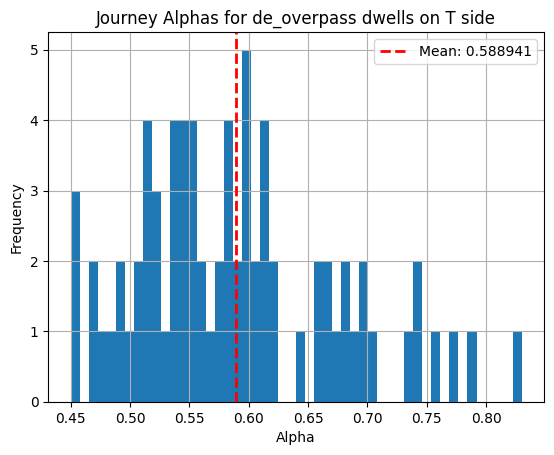

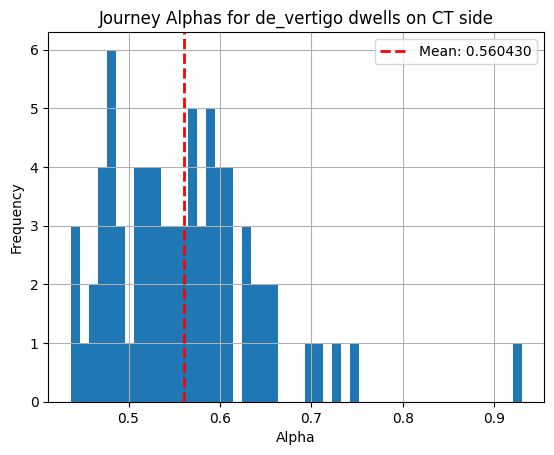

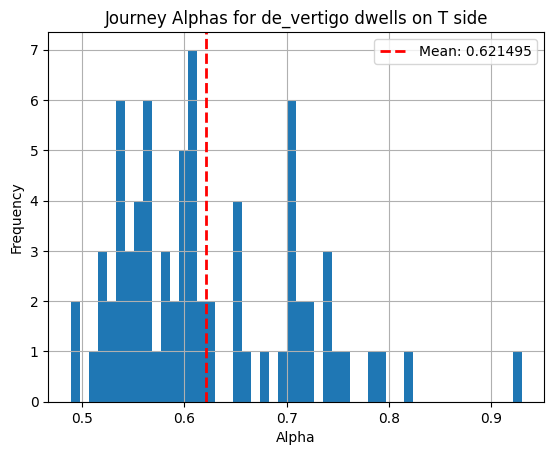

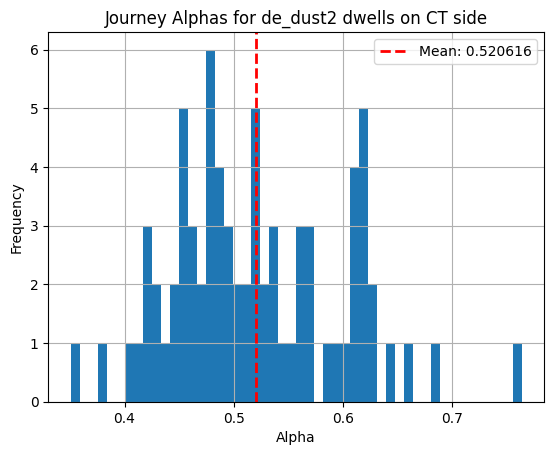

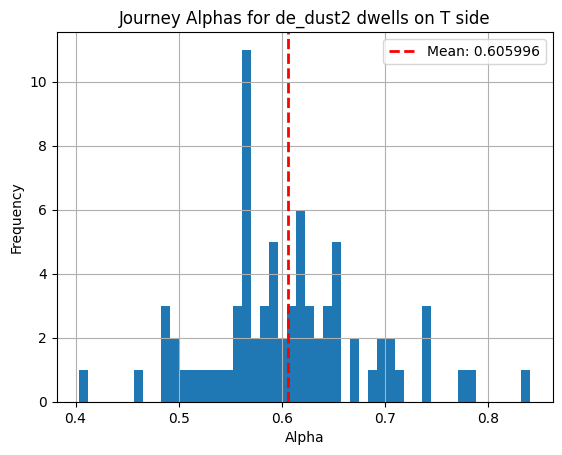

In [15]:
for map_name in all_maps:
    for s in aggregate_df.side.unique():
        plt.figure()  # Create a new figure for each histogram
        filtered_data = aggregate_df.loc[(aggregate_df['mapName'] == map_name) & (aggregate_df['side'] == s)]['alpha_j_mean']
        filtered_data = filtered_data[filtered_data <= 1]
        filtered_data.hist(bins=50)
        mean_alpha = filtered_data.mean()
        plt.axvline(mean_alpha, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_alpha:.6f}')

        plt.title(f"Journey Alphas for {map_name} dwells on {s} side")
        plt.xlabel('Alpha')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()  # Display the histogram

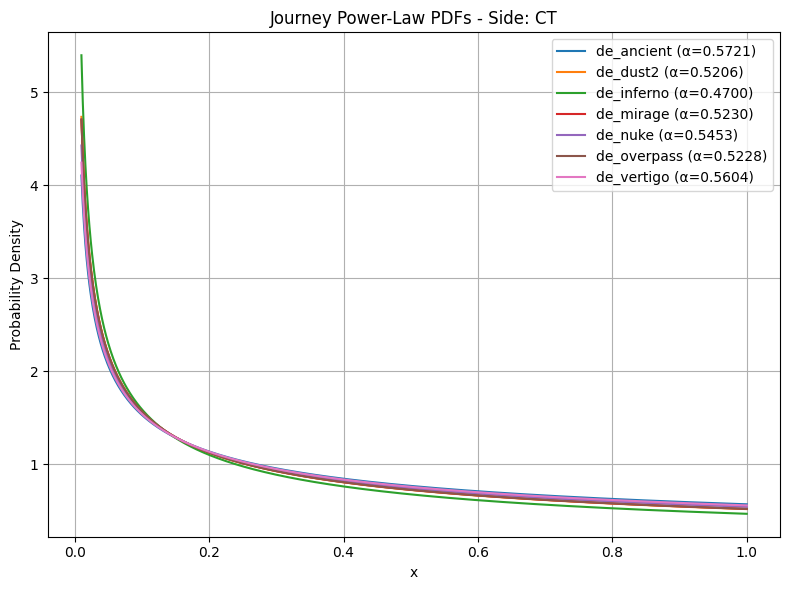

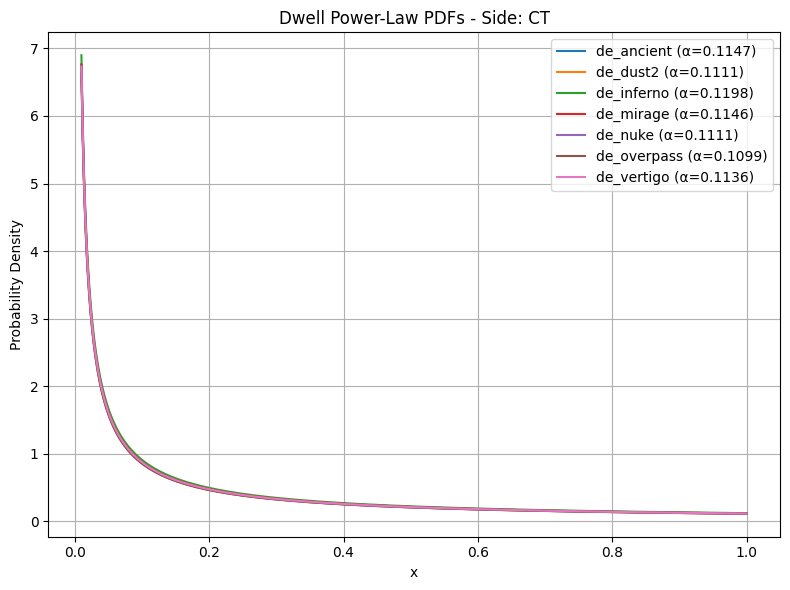

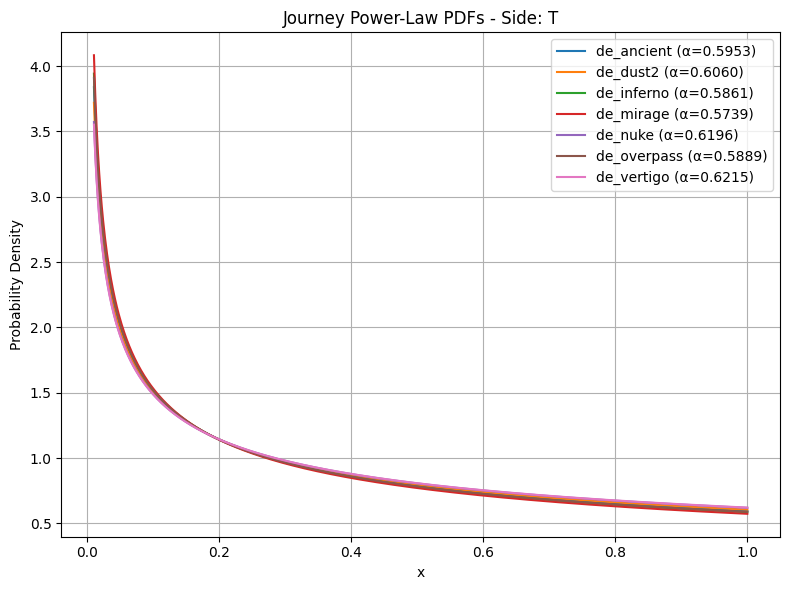

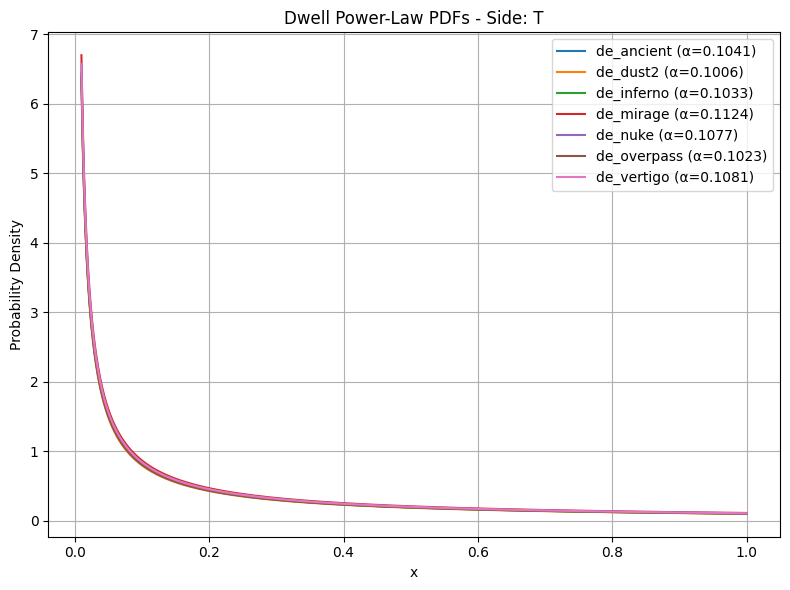

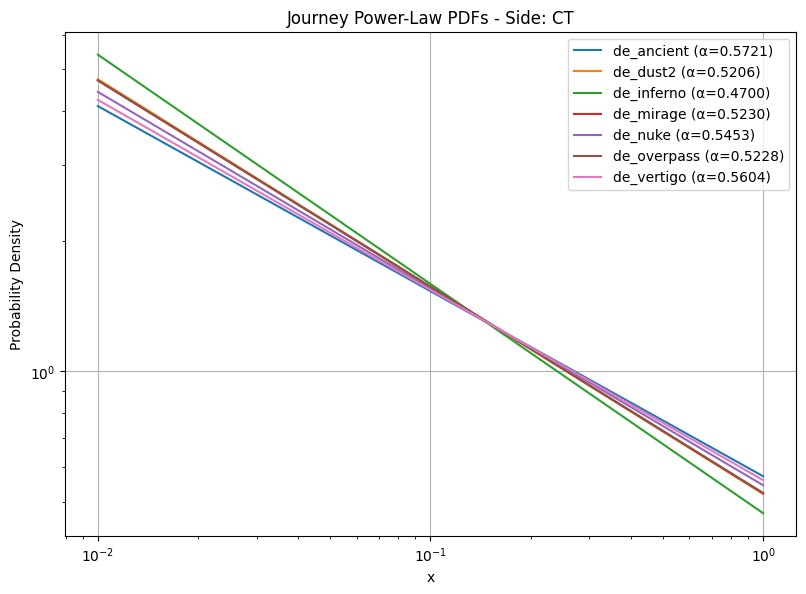

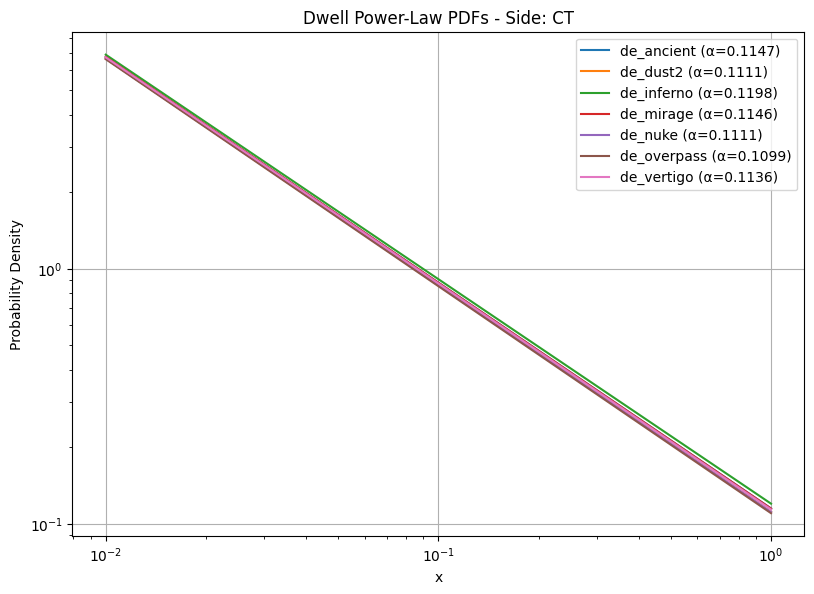

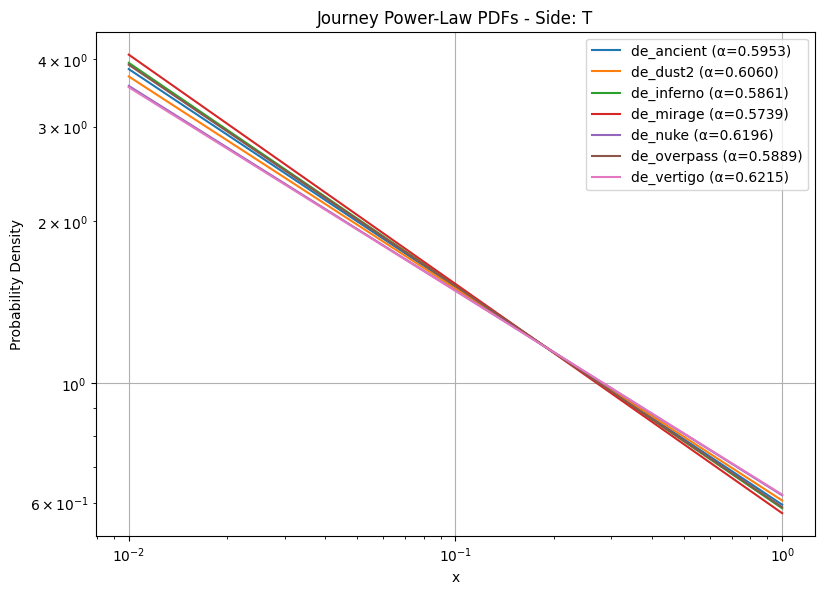

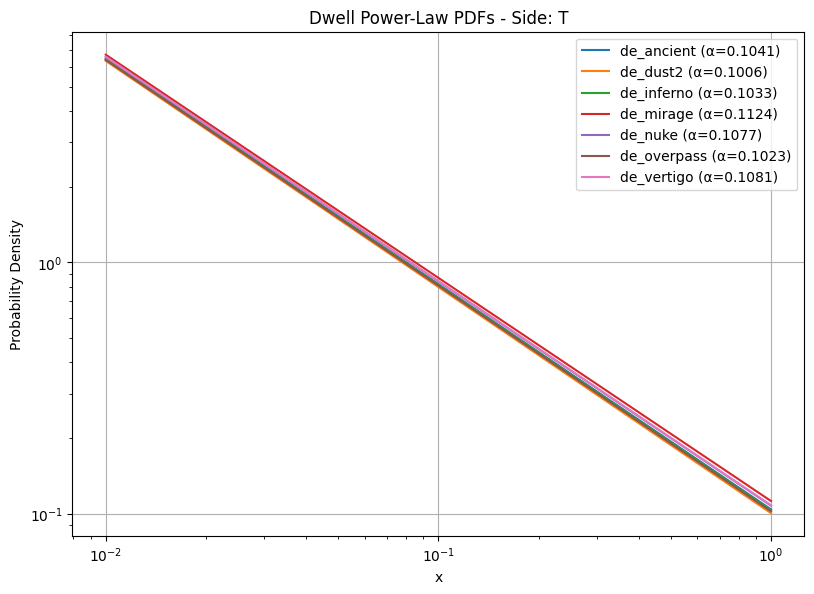

In [16]:
# Set x-axis for PDFs
x = np.linspace(0.01, 1, 1000)
# Group by side (CT or T)
for i in [0,1]:
    for side, side_df in aggregate_df.groupby('side'):

        # Plot for journeys
        plt.figure(figsize=(8, 6))
        for map_name, map_df in side_df.groupby('mapName'):
            mean_journey_alpha = map_df.loc[map_df.alpha_j_mean <= 1]['alpha_j_mean'].mean()
            rv = powerlaw(a=mean_journey_alpha)
            plt.plot(x, rv.pdf(x), label=f'{map_name} (α={mean_journey_alpha:.4f})')
        plt.title(f'Journey Power-Law PDFs - Side: {side}')
        plt.xlabel('x')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if i:
            plt.yscale('log')
            plt.xscale('log')
        plt.show()

        # Plot for dwells
        plt.figure(figsize=(8, 6))
        for map_name, map_df in side_df.groupby('mapName'):
            mean_dwell_alpha = map_df.loc[map_df.alpha_d_mean <= 1]['alpha_d_mean'].mean()
            rv = powerlaw(a=mean_dwell_alpha)
            plt.plot(x, rv.pdf(x), label=f'{map_name} (α={mean_dwell_alpha:.4f})')
        plt.title(f'Dwell Power-Law PDFs - Side: {side}')
        plt.xlabel('x')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if i:
            plt.yscale('log')
            plt.xscale('log')
        plt.show()
